# Technical Skills Assessment  
**State of Florida Employee Position**  
_State of Florida Agency_  

## Objectives

- Develop a 14-month forecast for Real Property Mortgage Foreclosure filings *in Excel*.
- Write in Word a one-page explanation of methodology and expected trends

## Exploratory Data Analysis

All statistical work begins with exploratory data analysis (EDA). This is looking at the raw data, summary graphs and statistics which give the analyst and idea of what the data looks like. Based on these impressions the analyst can then make a decision on how to proceed.

In [3]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Notebook settings
figure_width = 18
figure_height = 12

# Pre-processing / Data wrangling
data = pd.read_excel("Mortgage Foreclosure Forecast.xlsx", skiprows=4, dtype={"a": str, "b": float}, index_col=0)  # Import data
data.columns = ["Foreclosures"]  # Rename columns
data.index.name = "Date"  # Name index
data = data.drop(index=data.index[-3:])  # Drop last three rows

print(data.iloc[-5:,:])  # Visually inspect results

        Foreclosures
Date                
202302           NaN
202303           NaN
202304           NaN
202305           NaN
202306           NaN


In [4]:
index0 = data.index
series = pd.to_datetime(index0, format="%Y%m")  # Convert to Pandas datetime object
series = pd.DatetimeIndex(series, freq="infer")  # Convert to Pandas DatetimeIndex object
data.index = series.to_period("M")  # Convert to Pandas PeriodIndex object
print(f"The periodicity of the time variable is: {data.index.freq} or {data.index.freqstr}")  # The periodicity is monthly

# Separate into labeled and unlabeled (test) data
labeledData = data[data.iloc[:,0].notna()]
testdata = data[data.iloc[:,0].isna()]

print("\nTraining data:\n")
print(labeledData.head())
print("\nTest data:\n")
print(testdata.head())

The periodicity of the time variable is: <MonthEnd> or M

Training data:

         Foreclosures
Date                 
2005-06        4673.0
2005-07        4423.0
2005-08        4844.0
2005-09        4585.0
2005-10        3896.0

Test data:

         Foreclosures
Date                 
2022-05           NaN
2022-06           NaN
2022-07           NaN
2022-08           NaN
2022-09           NaN


One of the simplest ways to see raw data is using a scatter plot

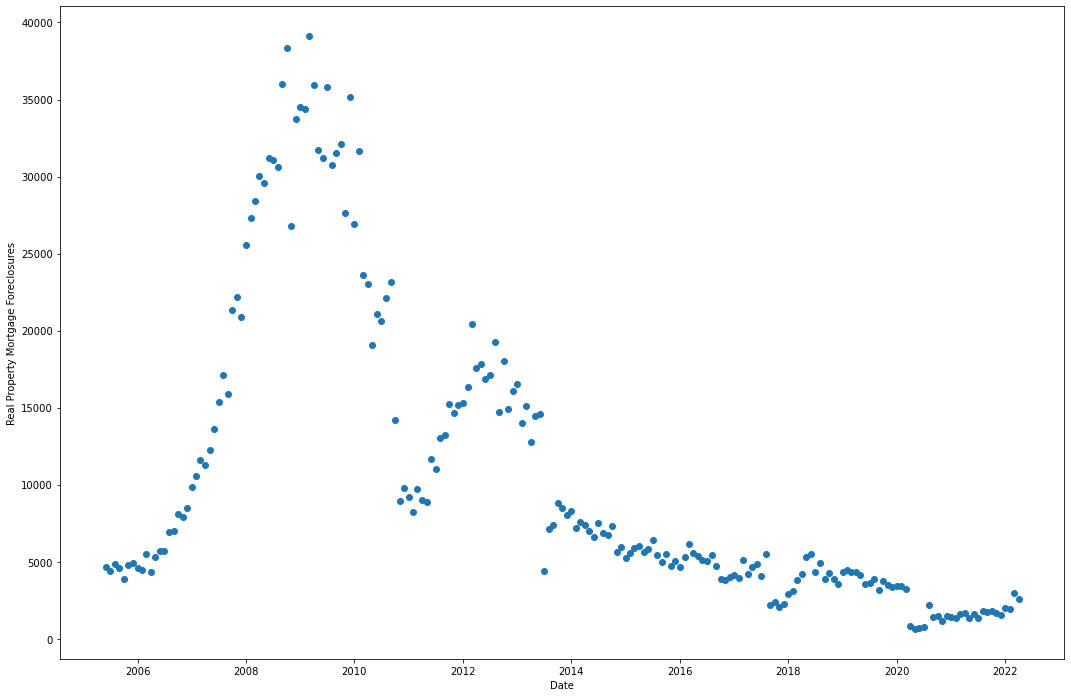

In [5]:
fig1 = plt.figure()
plt.scatter(labeledData.index.to_timestamp(), labeledData["Foreclosures"])
plt.xlabel("Date")
plt.ylabel("Real Property Mortgage Foreclosures")
fig1.set_figheight(figure_height)
fig1.set_figwidth(figure_width)

We see in the above visualization a large peak in foreclsoures focused around 2008, which coincides with the [subprime mortgage crisis](https://en.wikipedia.org/wiki/Subprime_mortgage_crisis). Interestingly there is another peak after 2012, and more anomalies around 2018 and 2020. Because there are multiple apparent anomalies, and because our one and only explanatory variable is a time variable, the best course of action is to use time series analysis to see if there is any periodic pattern in our data.

In [6]:
pli = [0.25, 0.5, 0.75, 0.80]  # list of proportions for train/eval split
results = {pr: {} for pr in pli}
summary = {pr: {} for pr in pli}
for pr in pli:
    traindata, evaldata = temporal_train_test_split(labeledData, train_size=pr)
    model = AutoARIMA(sp=12)  # Use sp=12 if you have monthly data. sp = season periodicity (?)

    # ignore predictable errors
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        warnings.simplefilter("ignore", ConvergenceWarning, lineno=604)  # ML optimization failed to converged.
        warnings.simplefilter("ignore", UserWarning, lineno=966)  # Non-stationary starting AR parameters found.
        warnings.simplefilter("ignore", UserWarning, lineno=978)  # Non-invertible starting MA parameters found.
        warnings.simplefilter("ignore", UserWarning, lineno=997)  # Non-invertible starting seasonal MA.
        warnings.simplefilter("ignore", UserWarning, lineno=1009)  # Non-stationary starting seasonal AR.

        model.fit(traindata["Foreclosures"])  # Train model
    
    # Store results
    results[pr]["model"] = model
    fh_train = np.arange(1, len(traindata))
    fh_eval = np.arange(1, len(evaldata))
    fh_test = np.arange(1, len(evaldata) + len(testdata))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning, lineno=100)  # FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
        warnings.simplefilter("ignore", FutureWarning, lineno=1543)  # In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False
        results[pr]["predict eval"] = model.predict(fh_eval)  # Predict on eval data
        summary[pr]["score eval"] = model.score(fh_eval)  # Get accuracy score on eval data
        results[pr]["predict test"] = model.predict(fh_test)  # Predict on test data
        summary[pr]["score test"] = model.score(fh_test)  # Get accuracy score on test data


Below we have a summary model performance using Mean Absolute Percent Errors (MAPE). The results are comparable for all model types.

In [7]:
print(pd.DataFrame.from_dict(summary))

                0.25      0.50      0.75      0.80
score eval  1.996501  1.950511  1.962993  1.979599
score test  1.996331  1.937802  1.952993  1.972696


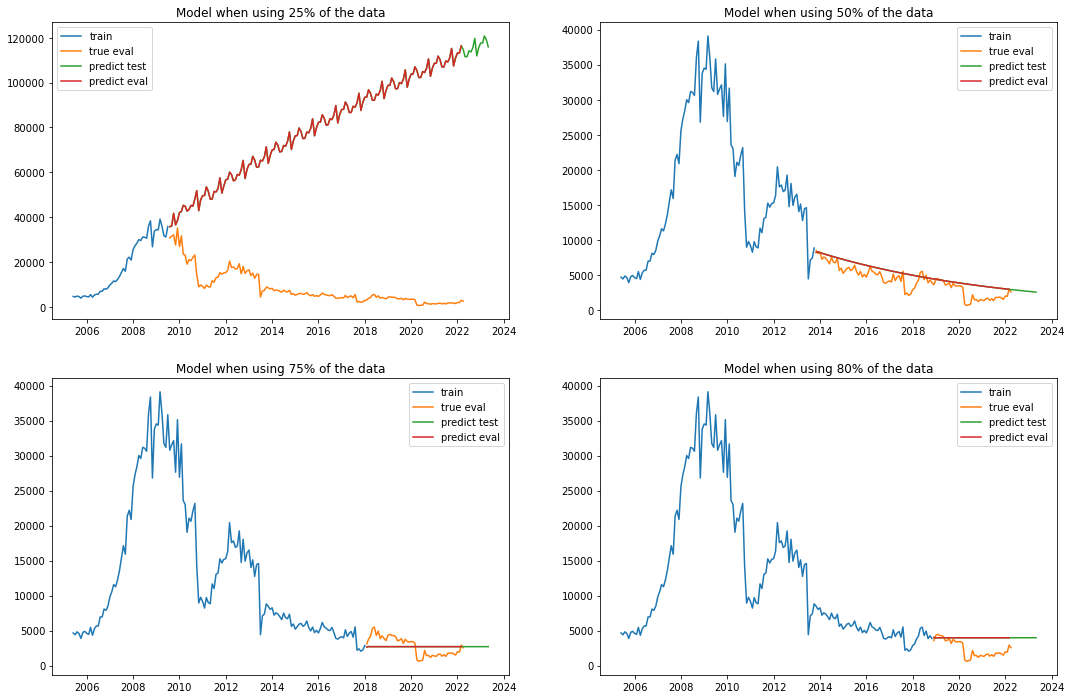

In [8]:
fig2, axs = plt.subplots(2, 2)

for ax, pr in zip(axs.flatten(), pli):
    traindata, evaldata = temporal_train_test_split(labeledData, train_size=pr)
    ax.plot(traindata.index.to_timestamp(), traindata.values, label="train")
    ax.plot(evaldata.index.to_timestamp(), evaldata.values, label="true eval")
    ax.plot(results[pr]["predict test"].index.to_timestamp(), results[pr]["predict test"].values, label="predict test")
    ax.plot(results[pr]["predict eval"].index.to_timestamp(), results[pr]["predict eval"].values, label="predict eval")
    ax.legend()
    ax.set_title(f"Model when using {pr:.0%} of the data")
fig2.set_figheight(figure_height)
fig2.set_figwidth(figure_width)

## Prediction and Conclusion
Although the MAPE were almost indistinguishable between the models and the evaluation and test sets, visual inspection reveals that the second model, using only 50% of the data, has a trend which most closely approximates the data. Below are the predictions requested.

In [9]:
print(results[0.5]["predict test"][-len(testdata):].round(2))

2022-04    2908.55
2022-05    2878.35
2022-06    2848.47
2022-07    2818.89
2022-08    2789.63
2022-09    2760.66
2022-10    2732.00
2022-11    2703.64
2022-12    2675.57
2023-01    2647.79
2023-02    2620.30
2023-03    2593.09
2023-04    2566.17
2023-05    2539.53
Freq: M, dtype: float64


However, we must ask ourselves, how confident are we in these results, and is there a theoretical, or methodoligcal, foundation for our predictions? A variance forecast will tell us the range of accuracy we expect with each prediction, and then we can decide if the range is within our tolerance, our requisite precision. It would also help determine if the models are significantly different, despite their similar MAPE scores.

The question posed at the beginning, to predict values based on this data, seems simple, but simple questions do not always have simple answers. Indeed, people dedicate their lives to the study of economic phenomena, like foreclosure rates, and even large institutions like banks, universities, and government agencies spend large amounts of time and resources to tackle these questions. There are more appropriate variables to regress on than time that can more accurately predict foreclosures. Economic indicators like unemployment, average credit score, inflation, etc., could be factors that can be used reliably across history, both past and present.